# Laboratorio 4 Malware families
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285

Oscar Esteba Donis - 21610

# Parte 1
## Creación del dataset

In [89]:
import os
import pefile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

In [90]:
dataset = [] # Lista que contendrá las instancias de nuestro dataset

for filename in os.listdir("MALWR"): # Iteramos sobre los archivos en la carpeta MALWR
    filepath = os.path.join("MALWR", filename) # Obtenemos la ruta completa del archivo

    try:
        pe = pefile.PE(filepath) # Cargamos el archivo PE en memoria
        file_size = os.path.getsize(filepath) # Obtenemos el tamaño del archivo en bytes
        creation_time = os.path.getctime(filepath) # Obtenemos la fecha de creación del archivo
        modification_time = os.path.getmtime(filepath) # Obtenemos la fecha de modificación del archivo

        sections = [section.Name.decode().strip('\x00') for section in pe.sections] # Obtenemos las secciones del archivo
        num_sections = len(sections) # Obtenemos el número de secciones del archivo

        # Llamadas a funciones importadas
        imported_functions = [] # Lista que contendrá las funciones importadas
        for entry in pe.DIRECTORY_ENTRY_IMPORT: # Iteramos sobre las entradas de la tabla de importación
            for function in entry.imports: # Iteramos sobre las funciones importadas
                imported_functions.append(function.name.decode()) # Agregamos la función a la lista

        embedded_strings = [] # Lista que contendrá las cadenas de texto incrustadas
        try:
            for s in pe.strings: # Iteramos sobre las cadenas de texto incrustadas
                if isinstance(s, bytes): # Si la cadena es de tipo bytes la decodificamos
                    embedded_strings.append(s.decode(errors='ignore')) # Agregamos la cadena a la lista
                else:
                    embedded_strings.append(s) # Agregamos la cadena a la lista
        except AttributeError:
            pass

        instance = [file_size, creation_time, modification_time, num_sections, sections, imported_functions, embedded_strings] # Creamos una instancia con los atributos del archivo
        dataset.append(instance) # Agregamos la instancia a nuestro dataset
    except Exception as e:
        print(f"{str(e)}")

columns = ["Tamaño del archivo", "Tiempo de creación", "Tiempo de modificación", "Número de secciones", "Secciones del archivo", "Llamadas a funciones importadas", "Cadenas de texto incrustadas"]
df = pd.DataFrame(dataset, columns=columns)
print("Encabezados de nuestro Dataset creado:")
print(df.head())

'DOS Header magic not found.'
Encabezados de nuestro Dataset creado:
   Tamaño del archivo  Tiempo de creación  Tiempo de modificación  \
0              285184        1.741100e+09            1.535140e+09   
1               15360        1.741100e+09            1.535140e+09   
2              295424        1.741100e+09            1.535140e+09   
3               15360        1.741100e+09            1.535140e+09   
4               16896        1.741100e+09            1.535140e+09   

   Número de secciones          Secciones del archivo  \
0                    3             [UPX0, UPX1, UPX2]   
1                    3         [.text, .rdata, .data]   
2                    3            [UPX0, UPX1, .rsrc]   
3                    3         [.text, .rdata, .data]   
4                    4  [.text, .rdata, .data, .rsrc]   

                     Llamadas a funciones importadas  \
0  [RegSaveKeyA, BitBlt, LoadLibraryA, ExitProces...   
1  [CreateFileA, LocalAlloc, Sleep, CreateThread,...   
2  [R

In [91]:
df.head()

,Tamaño del archivo,Tiempo de creación,Tiempo de modificación,Número de secciones,Secciones del archivo,Llamadas a funciones importadas,Cadenas de texto incrustadas
0,285184,1.741100e+09,1.535140e+09,3,"[UPX0, UPX1, UPX2]","[RegSaveKeyA, BitBlt, LoadLibraryA, ExitProces...",[]
1,15360,1.741100e+09,1.535140e+09,3,"[.text, .rdata, .data]","[CreateFileA, LocalAlloc, Sleep, CreateThread,...",[]
2,295424,1.741100e+09,1.535140e+09,3,"[UPX0, UPX1, .rsrc]","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...",[]
3,15360,1.741100e+09,1.535140e+09,3,"[.text, .rdata, .data]","[CreateFileA, LocalAlloc, Sleep, CreateThread,...",[]
4,16896,1.741100e+09,1.535140e+09,4,"[.text, .rdata, .data, .rsrc]","[GetModuleHandleA, GetWindowsDirectoryA, GetMo...",[]


In [92]:
df.describe()

,Tamaño del archivo,Tiempo de creación,Tiempo de modificación,Número de secciones
count,13.000000,1.300000e+01,1.300000e+01,13.000000
mean,104487.384615,1.741100e+09,1.535140e+09,3.076923
std,139879.808920,3.591415e-02,3.094660e+00,0.277350
min,14336.000000,1.741100e+09,1.535140e+09,3.000000
25%,15360.000000,1.741100e+09,1.535140e+09,3.000000
50%,15360.000000,1.741100e+09,1.535140e+09,3.000000
75%,285184.000000,1.741100e+09,1.535140e+09,3.000000
max,344576.000000,1.741100e+09,1.535140e+09,4.000000


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Tamaño del archivo               13 non-null     int64  
 1   Tiempo de creación               13 non-null     float64
 2   Tiempo de modificación           13 non-null     float64
 3   Número de secciones              13 non-null     int64  
 4   Secciones del archivo            13 non-null     object 
 5   Llamadas a funciones importadas  13 non-null     object 
 6   Cadenas de texto incrustadas     13 non-null     object 
dtypes: float64(2), int64(2), object(3)
memory usage: 856.0+ bytes


## Exploración y pre-procesamiento de datos

In [94]:
df['Cantidad de cadenas incrustadas'] = df['Cadenas de texto incrustadas'].apply(len)
print(df['Cantidad de cadenas incrustadas'].value_counts())

Cantidad de cadenas incrustadas
0    13
Name: count, dtype: int64


In [95]:
df.drop('Cadenas de texto incrustadas', axis=1, inplace=True)
df.drop('Cantidad de cadenas incrustadas', axis=1, inplace=True)

In [96]:
df.rename(columns={
    'Tamaño del archivo': 'file_size',
    'Tiempo de creación': 'creation_time',
    'Tiempo de modificación': 'modification_time',
    'Número de secciones': 'num_sections',
    'Secciones del archivo': 'file_sections',
    'Llamadas a funciones importadas': 'imported_function_calls',
    'Cadenas de texto incrustadas': 'embedded_strings',
    'Cantidad de cadenas incrustadas': 'num_embedded_strings'
}, inplace=True)
print("Encabezado del Dataset con Nombres de Columnas Actualizados:")
df.head()

Encabezado del Dataset con Nombres de Columnas Actualizados:


,file_size,creation_time,modification_time,num_sections,file_sections,imported_function_calls
0,285184,1.741100e+09,1.535140e+09,3,"[UPX0, UPX1, UPX2]","[RegSaveKeyA, BitBlt, LoadLibraryA, ExitProces..."
1,15360,1.741100e+09,1.535140e+09,3,"[.text, .rdata, .data]","[CreateFileA, LocalAlloc, Sleep, CreateThread,..."
2,295424,1.741100e+09,1.535140e+09,3,"[UPX0, UPX1, .rsrc]","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd..."
3,15360,1.741100e+09,1.535140e+09,3,"[.text, .rdata, .data]","[CreateFileA, LocalAlloc, Sleep, CreateThread,..."
4,16896,1.741100e+09,1.535140e+09,4,"[.text, .rdata, .data, .rsrc]","[GetModuleHandleA, GetWindowsDirectoryA, GetMo..."


In [97]:
df_processed = df.copy()

# Tokenizar las columnas de listas
mlb_sections = MultiLabelBinarizer()
mlb_imported_functions = MultiLabelBinarizer()

# Tokenización de las secciones del archivo
sections_encoded = pd.DataFrame(mlb_sections.fit_transform(df_processed['file_sections']), columns=mlb_sections.classes_, index=df_processed.index)

# Tokenización de las llamadas a funciones importadas
imported_functions_encoded = pd.DataFrame(mlb_imported_functions.fit_transform(df_processed['imported_function_calls']), columns=mlb_imported_functions.classes_, index=df_processed.index)

df_processed = pd.concat([df_processed, sections_encoded, imported_functions_encoded], axis=1)
df_processed.drop(['file_sections', 'imported_function_calls'], axis=1, inplace=True)
scaler = MinMaxScaler()
df_processed[['file_size', 'creation_time', 'modification_time']] = scaler.fit_transform(df_processed[['file_size', 'creation_time', 'modification_time']])
print("Encabezado del Dataset ya Procesado:")
df_processed.head()

Encabezado del Dataset ya Procesado:


,file_size,creation_time,modification_time,num_sections,.data,.rdata,.rsrc,.text,UPX0,UPX1,...,strcpy,strlen,strstr,time,wcscat,wcscmp,wcscpy,wcslen,wcsrchr,wcstombs
0,0.820155,0.000000,0.625,3,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0.003101,0.080887,0.000,3,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0.851163,0.164867,0.625,3,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0.003101,0.255180,0.000,3,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0.007752,0.329884,0.000,4,1,1,1,1,0,0,...,1,1,1,1,0,0,0,0,0,0


# Parte 2 
## Implementación de algoritmos
### Algoritmo Kmeans

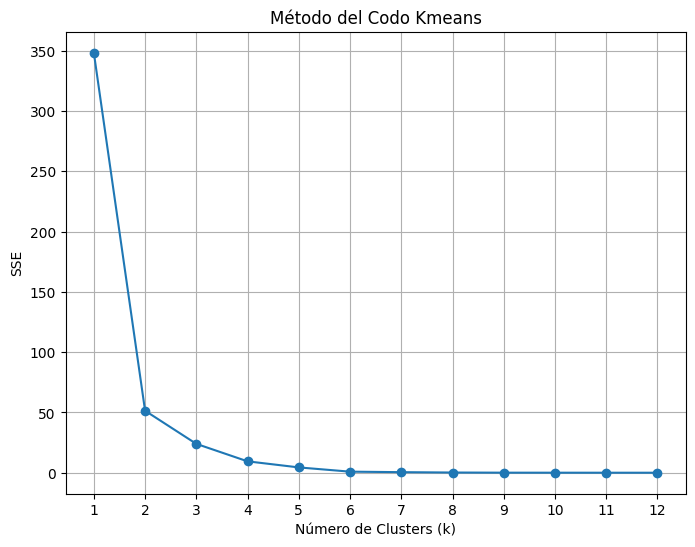

In [ ]:
sse = []
for k in range(1, 13): # Probamos con un rango de 1 a 12 clusters
    kmeans = KMeans(n_clusters=k, random_state=42) # Creamos un modelo KMeans
    kmeans.fit(df_processed) # Ajustamos el modelo
    sse.append(kmeans.inertia_) # Obtenemos el SSE

plt.figure(figsize=(8, 6)) # Creamos una figura
plt.plot(range(1, 13), sse, marker='o') # Graficamos el SSE
plt.title('Método del Codo Kmeans') # Título del gráfico
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

Explicación: 

Para k=2, el coeficiente de Silhouette es: 0.7643004597531723
Para k=3, el coeficiente de Silhouette es: 0.7563506165219093
Para k=4, el coeficiente de Silhouette es: 0.6892854160045141
Para k=5, el coeficiente de Silhouette es: 0.660161215019763
Para k=6, el coeficiente de Silhouette es: 0.6807756417739484
Para k=7, el coeficiente de Silhouette es: 0.4480720450364529
Para k=8, el coeficiente de Silhouette es: 0.34521853211967957
Para k=9, el coeficiente de Silhouette es: 0.3853736250487023
Para k=10, el coeficiente de Silhouette es: 0.30014740919414895
Para k=11, el coeficiente de Silhouette es: 0.21887253928555964
Para k=12, el coeficiente de Silhouette es: 0.15087173231174655


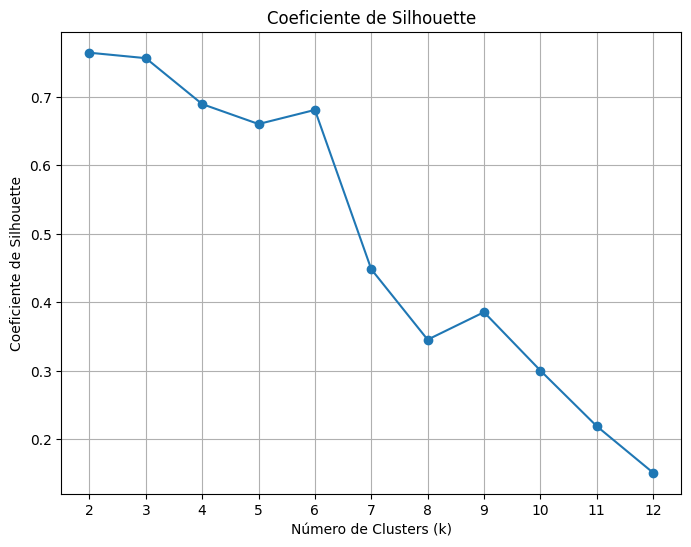

In [ ]:
silhouette_scores = [] # Lista que contendrá los coeficientes de Silhouette

# Calcular el coeficiente de Silhouette para diferentes valores de k
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, random_state=42) # Creamos un modelo KMeans
    cluster_labels = kmeans.fit_predict(df_processed) # Ajustamos el modelo y obtenemos las etiquetas de los clusters
    silhouette_avg = silhouette_score(df_processed, cluster_labels) # Calculamos el coeficiente de Silhouette
    silhouette_scores.append(silhouette_avg) # Agregamos el coeficiente a la lista
    print(f"Para k={k}, el coeficiente de Silhouette es: {silhouette_avg}") # Mostramos el coeficiente de Silhouette

plt.figure(figsize=(8, 6)) # Creamos una figura
plt.plot(range(2, 13), silhouette_scores, marker='o')
plt.title('Coeficiente de Silhouette')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhouette')
plt.xticks(range(2, 13))
plt.grid(True)
plt.show()

Explicación:

In [ ]:
# Ajustar el modelo KMeans con k=2
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(df_processed) # Ajustamos el modelo y obtenemos las etiquetas de los clusters

# Crear un DataFrame con los resultados
malwr_folder = "MALWR"
malware_files = os.listdir(malwr_folder) # Obtenemos los nombres de los archivos

# Crear un DataFrame con los resultados de los clusters
min_length = min(len(malware_files), len(cluster_labels)) # Obtenemos la longitud mínima
result_df = pd.DataFrame({
    'File Name': malware_files[:min_length], # Obtenemos los nombres de los archivos
    'Cluster': cluster_labels[:min_length] # Obtenemos las etiquetas de los clusters
})

# Ordenar el DataFrame por el cluster
result_df.sort_values(by='Cluster', inplace=True)

# Mostrar los resultados
for cluster_id, group in result_df.groupby('Cluster'):
    print(f"\nGrupo {cluster_id + 1}:")
    for file_name in group['File Name']:
        print(f"- {file_name}")


Grupo 1:
- B98hX8E8622C393D7E832D39E620EAD5D3B49
- FGTR43_EF8E0FB20E7228C7492CCDC59D87C690
- GBV66_8F259BB36E00D124963CFA9B86F502E
- GFT4_7DDD3D72EAD03C7518F5D47650C8572
- K99_C3A9A7B026BFE0E55FF219FD6AA7D94
- PL98_BD8B082B7711BC980252F988BB0CA936
- RTC_7F85D7F628CE62D1D8F7B39D8940472

Grupo 2:
- .DS_Store
- DS22_A670D13D4D014169C4080328B8FEB86
- KLp90_6D5C8FC4B14559F73B6136D85B94198
- POL55_A4F1ECC4D25B33395196B5D51A06790
- QW2_4C6BDDCCA2695D6202DF38708E14FC7E
- SAM_B659D71AE168E774FAAF38DB30F4A84


### Algoritmo K-Medoids

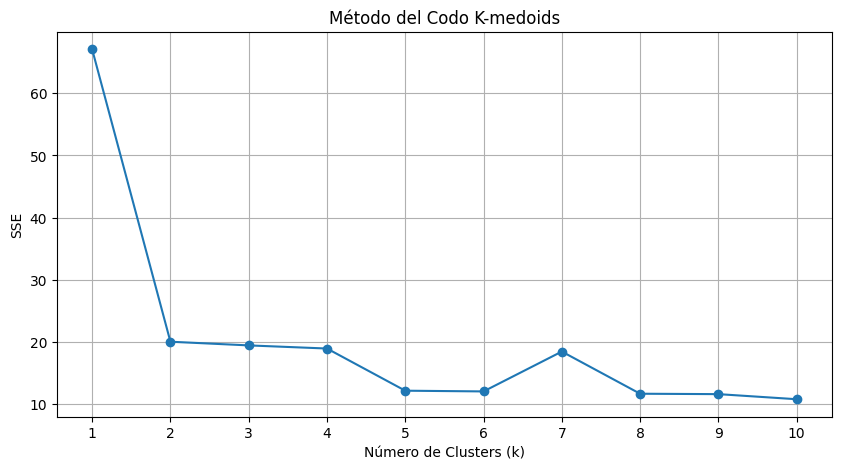

In [ ]:
def elbow_method_kmedoids(df):
    # Calcular el SSE para diferentes valores de k
    max_clusters = min(len(df) - 1, 10)  # Número máximo de clusters
    
    sum_of_squared_distances = [] # Lista que contendrá el SSE
    k_values = range(1, max_clusters + 1) # Rango de valores de k
    for k in k_values: # Iteramos sobre los valores de k
        kmedoids = KMedoids(n_clusters=k, random_state=42) # Creamos un modelo KMedoids
        kmedoids.fit(df) # Ajustamos el modelo
        sum_of_squared_distances.append(kmedoids.inertia_) # Obtenemos el SSE y lo agregamos a la lista
    return sum_of_squared_distances, max_clusters # Retornamos el SSE y el número máximo de clusters

def plot_elbow_kmedoids(df): # Función para graficar el método del codo
    elbow_scores, max_clusters = elbow_method_kmedoids(df) # Obtenemos el SSE y el número máximo de clusters
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), elbow_scores, marker='o', linestyle='-') # Graficamos el SSE
    plt.title('Método del Codo K-medoids')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('SSE')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True)
    plt.show()

def silhouette_method_kmedoids(df): # Función para calcular el coeficiente de Silhouette
    max_clusters = min(len(df) - 1, 10) # Número máximo de clusters
    silhouette_scores = [] # Lista que contendrá los coeficientes de Silhouette 
    for k in range(2, max_clusters + 1): # Iteramos sobre los valores de k
        kmedoids = KMedoids(n_clusters=k, random_state=42) # Creamos un modelo KMedoids
        cluster_labels = kmedoids.fit_predict(df) # Ajustamos el modelo y obtenemos las etiquetas de los clusters
        if len(set(cluster_labels)) > 1: # Si se generaron más de un clúster
            silhouette_avg = silhouette_score(df, cluster_labels) # Calculamos el coeficiente de Silhouette
            silhouette_scores.append(silhouette_avg)
            print(f"Para k={k}, el coeficiente de Silhouette es: {silhouette_avg}") # Mostramos el coeficiente de Silhouette
        else:
            print(f"Para k={k}, el algoritmo solo generó un único clúster.")
            silhouette_scores.append(None)
    return silhouette_scores, max_clusters

def plot_silhouette_kmedoids(df): # Función para graficar el coeficiente de Silhouette
    silhouette_scores, max_clusters = silhouette_method_kmedoids(df) # Obtenemos el coeficiente de Silhouette y el número máximo de clusters
    plt.figure(figsize=(10, 5)) # Creamos una figura
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o') # Graficamos el coeficiente de Silhouette
    plt.title('Coeficiente de Silhouette K-medoids')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Coeficiente de Silhouette')
    plt.xticks(range(2, max_clusters + 1))
    plt.grid(True)
    plt.show()

# Plot results
plot_elbow_kmedoids(df_processed)

Explicación:

Para k=2, el coeficiente de Silhouette es: 0.7643004597531723
Para k=3, el coeficiente de Silhouette es: 0.466617520648662
Para k=4, el coeficiente de Silhouette es: 0.3766292706737096
Para k=5, el coeficiente de Silhouette es: 0.3096740055679258
Para k=6, el coeficiente de Silhouette es: 0.18241236059798993
Para k=7, el coeficiente de Silhouette es: 0.2546104109880022
Para k=8, el coeficiente de Silhouette es: 0.18768821221365478
Para k=9, el coeficiente de Silhouette es: 0.036383038339203116
Para k=10, el coeficiente de Silhouette es: -0.11295552491790604


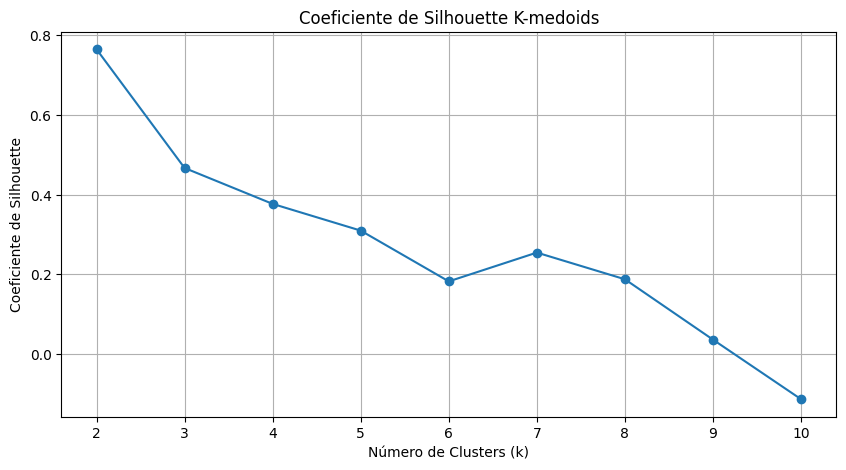

In [ ]:
plot_silhouette_kmedoids(df_processed) # Graficamos el coeficiente de Silhouette

Explicación:

In [ ]:
def kmedoids_clustering(df, num_clusters): # Función para realizar el clustering con K-medoids
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=42) # Creamos un modelo KMedoids
    cluster_labels = kmedoids.fit_predict(df) # Ajustamos el modelo y obtenemos las etiquetas de los clusters
    return cluster_labels

def print_clusters(cluster_labels, file_names): # Función para mostrar los resultados
    clusters = {} # Diccionario que contendrá los clusters
    for label, file_name in zip(cluster_labels, file_names): # Iteramos sobre las etiquetas de los clusters y los nombres de los archivos
        if label not in clusters: # Si la etiqueta no está en el diccionario
            clusters[label] = [] # Creamos una lista vacía para la etiqueta
        clusters[label].append(file_name) # Agregamos el nombre del archivo a la lista correspondiente

    for cluster_id, files in clusters.items(): # Iteramos sobre los clusters y los archivos
        print(f"Grupo {cluster_id + 1}:") # Mostramos el número de cluster
        for file_name in files:
            print(f"- {file_name}")

num_clusters = 2

cluster_labels = kmedoids_clustering(df_processed, num_clusters) # Realizamos el clustering con K-medoids

print_clusters(cluster_labels, malware_paths)

Grupo 1:
- MALWR\.DS_Store
- MALWR\DS22_A670D13D4D014169C4080328B8FEB86
- MALWR\KLp90_6D5C8FC4B14559F73B6136D85B94198
- MALWR\POL55_A4F1ECC4D25B33395196B5D51A06790
- MALWR\QW2_4C6BDDCCA2695D6202DF38708E14FC7E
- MALWR\SAM_B659D71AE168E774FAAF38DB30F4A84
Grupo 2:
- MALWR\B98hX8E8622C393D7E832D39E620EAD5D3B49
- MALWR\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690
- MALWR\GBV66_8F259BB36E00D124963CFA9B86F502E
- MALWR\GFT4_7DDD3D72EAD03C7518F5D47650C8572
- MALWR\K99_C3A9A7B026BFE0E55FF219FD6AA7D94
- MALWR\PL98_BD8B082B7711BC980252F988BB0CA936
- MALWR\RTC_7F85D7F628CE62D1D8F7B39D8940472


# Algoritmo 3 Extra Gemini

### Generando los embeddings de la información de nuestro dataset usando Gemini

Generating text features...
Generating embeddings...
Generated embeddings for 13 samples
Applying dimensionality reduction...
Skipped PCA due to small dataset size
Applied UMAP reduction with 5 neighbors

Performing clustering...


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



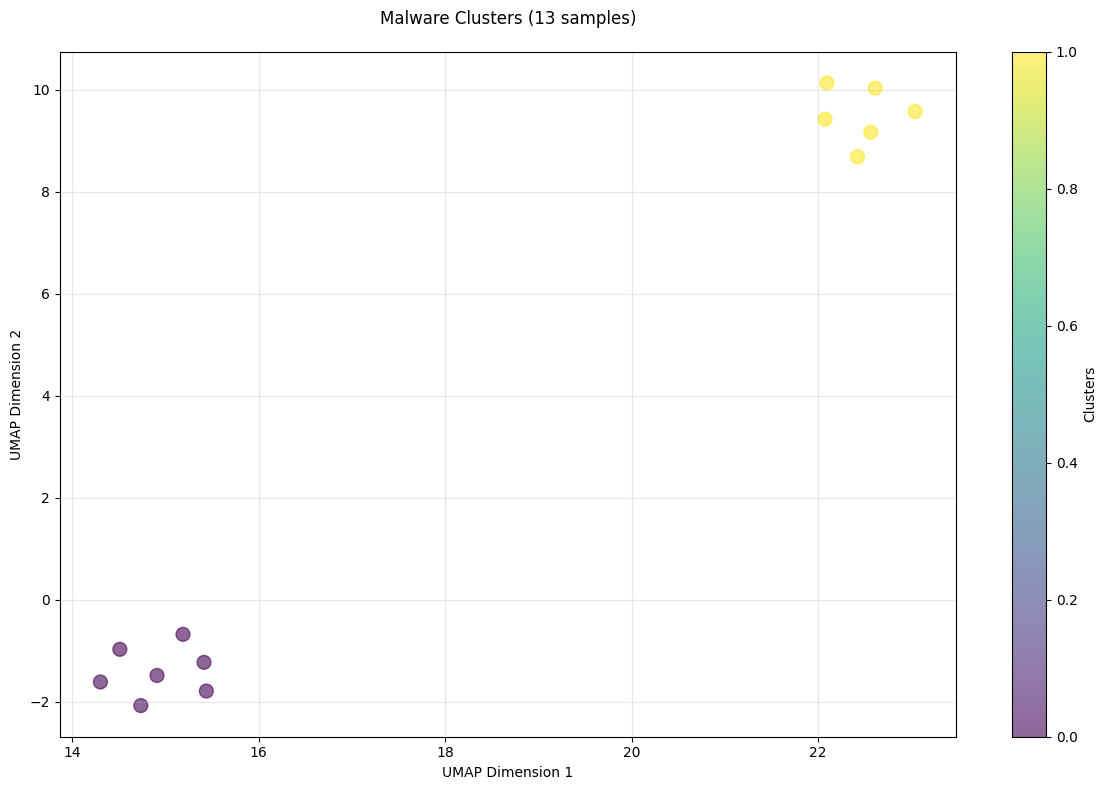


Silhouette Score: 0.744

Cluster Distribution:

Cluster 0: 7 samples
Files: [1, 3, 4, 5, 6, 8, 11]

Cluster 1: 6 samples
Files: [0, 2, 7, 9, 10, 12]

Results saved to clustering_results.csv


In [ ]:
import os
import pefile
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import google.generativeai as genai
from umap import UMAP
from sklearn.decomposition import PCA


# cargar el archivo de configuración
load_dotenv()
genai.configure(api_key=os.getenv('GEMINI_API_KEY')) # Configurar la API de Gemini

def get_embeddings(texts): # Función para generar embeddings
    """Generate embeddings using Gemini API"""
    model = 'models/embedding-001' # Modelo de embeddings
    embeddings = [] # Lista que contendrá los embeddings
    for text in texts: # Iteramos sobre los textos
        try: # Intentamos generar el embedding
            result = genai.embed_content(
                model=model, # Modelo de embeddings
                content=str(text), # Texto a procesar
                task_type="clustering" # Tipo de tarea
            )
            embeddings.append(result['embedding']) # Agregamos el embedding a la lista
        except Exception as e: # Manejo de excepciones
            print(f"Error processing text: {e}") # Mostramos el error
    return np.array(embeddings)

def create_text_features(row): # Función para combinar características relevantes en texto
    """Combine relevant features into text"""
    features = [] # Lista que contendrá las características
    if 'file_sections' in row: # Si hay secciones de archivo
        features.extend(row['file_sections']) # Agregamos las secciones
    if 'imported_function_calls' in row: # Si hay llamadas a funciones importadas
        features.extend(row['imported_function_calls']) # Agregamos las funciones importadas
    return ' '.join(map(str, features)) # Retornamos las características combinadas


print("Generating text features...") # Generar características de texto
text_features = df.apply(create_text_features, axis=1).tolist() # Aplicar la función a cada fila

print("Generating embeddings...") # Generar embeddings
embeddings = get_embeddings(text_features) # Obtener los embeddings
n_samples = len(embeddings) # Número de muestras
print(f"Generated embeddings for {n_samples} samples") # Mostrar el número de muestras

# Dimensionality reduction pipeline
print("Applying dimensionality reduction...")

# aplicar PCA si hay más de 50 muestras
if n_samples > 50:
    n_components = min(n_samples - 1, embeddings.shape[1], 50) # Limitar a 50 componentes
    pca = PCA(n_components=n_components) # Crear un modelo PCA
    embeddings_processed = pca.fit_transform(embeddings) # Ajustar y transformar los embeddings
    print(f"Applied PCA: reduced to {n_components} dimensions") # Mostrar el número de dimensiones
else:
    embeddings_processed = embeddings # Mantener los embeddings originales
    print("Skipped PCA due to small dataset size") # Mostrar mensaje de advertencia

# aplicar UMAP para reducir a 2 dimensiones
n_neighbors = min(n_samples - 1, 5)  # Limitar a 5 vecinos para conjuntos de datos pequeños
reducer = UMAP(
    n_components=2, # Reducir a 2 dimensiones
    random_state=42, # Semilla aleatoria
    min_dist=0.1,
    n_neighbors=n_neighbors, # Número de vecinos
    metric='euclidean'
)
reduced_embeddings = reducer.fit_transform(embeddings_processed) # Ajustar y transformar los embeddings
print(f"Applied UMAP reduction with {n_neighbors} neighbors") # Mostrar el número de vecinos

# Clustering
print("\nPerforming clustering...")
n_clusters = min(2, n_samples - 1) # Limitar a 2 clusters para conjuntos de datos pequeños
kmeans = KMeans(n_clusters=n_clusters, random_state=42) # Crear un modelo KMeans
clusters = kmeans.fit_predict(embeddings_processed) # Ajustar el modelo y obtener las etiquetas de los clusters

# Visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.6,
    s=100  
)

plt.title(f'Malware Clusters ({n_samples} samples)', pad=20)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Clusters')
plt.grid(True, alpha=0.3)


if 'file_name' in df.columns: # Si hay nombres de archivo
    for i, txt in enumerate(df['file_name']): # Iteramos sobre los nombres de archivo 
        plt.annotate(
            txt, # Texto 
            (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), # Coordenadas
            fontsize=8, # Tamaño de
            alpha=0.7, # Transparencia
            xytext=(5, 5),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

# metricas de clustering
if len(np.unique(clusters)) > 1: # Si hay más de un clúster
    silhouette_avg = silhouette_score(embeddings_processed, clusters) # Calcular el coeficiente de Silhouette
    print(f"\nSilhouette Score: {silhouette_avg:.3f}") # Mostrar el coeficiente de Silhouette

# distribución de clusters
print("\nCluster Distribution:")
for cluster in range(n_clusters): # Iteramos sobre los clusters
    count = (clusters == cluster).sum() # Contamos el número de muestras en el cluster
    files_in_cluster = df.index[clusters == cluster].tolist() # Obtenemos los archivos en el cluster
    print(f"\nCluster {cluster}: {count} samples") # Mostramos el número de muestras en el cluster
    print("Files:", files_in_cluster) # Mostramos los archivos en el cluster

# guardar resultados
results_df = pd.DataFrame({
    'File': df.index if 'file_name' not in df.columns else df['file_name'], # Nombres de archivo
    'Cluster': clusters, # Clusters
    'UMAP_1': reduced_embeddings[:, 0], # Coordenadas
    'UMAP_2': reduced_embeddings[:, 1] # Coordenadas
})
results_df.to_csv('clustering_results.csv') # Guardar los resultados en un archivo CSV
print("\nResults saved to clustering_results.csv") # Mostrar mensaje de éxito

## Comparando modelos
R//

# Analisis de Similitudes 

Analyzing strings...
Extracted 20 strings from MALWR\.DS_Store
Extracted 4788 strings from MALWR\B98hX8E8622C393D7E832D39E620EAD5D3B49
Extracted 236 strings from MALWR\DS22_A670D13D4D014169C4080328B8FEB86
Extracted 4965 strings from MALWR\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690
Extracted 240 strings from MALWR\GBV66_8F259BB36E00D124963CFA9B86F502E
Extracted 243 strings from MALWR\GFT4_7DDD3D72EAD03C7518F5D47650C8572
Extracted 236 strings from MALWR\K99_C3A9A7B026BFE0E55FF219FD6AA7D94
Extracted 235 strings from MALWR\KLp90_6D5C8FC4B14559F73B6136D85B94198
Extracted 5800 strings from MALWR\PL98_BD8B082B7711BC980252F988BB0CA936
Extracted 235 strings from MALWR\POL55_A4F1ECC4D25B33395196B5D51A06790
Extracted 5005 strings from MALWR\QW2_4C6BDDCCA2695D6202DF38708E14FC7E
Extracted 197 strings from MALWR\RTC_7F85D7F628CE62D1D8F7B39D8940472
Extracted 239 strings from MALWR\SAM_B659D71AE168E774FAAF38DB30F4A84
Extracted 191 strings from MALWR\VBMM9_149B7BD7218AAB4E257D28469FDDB0D


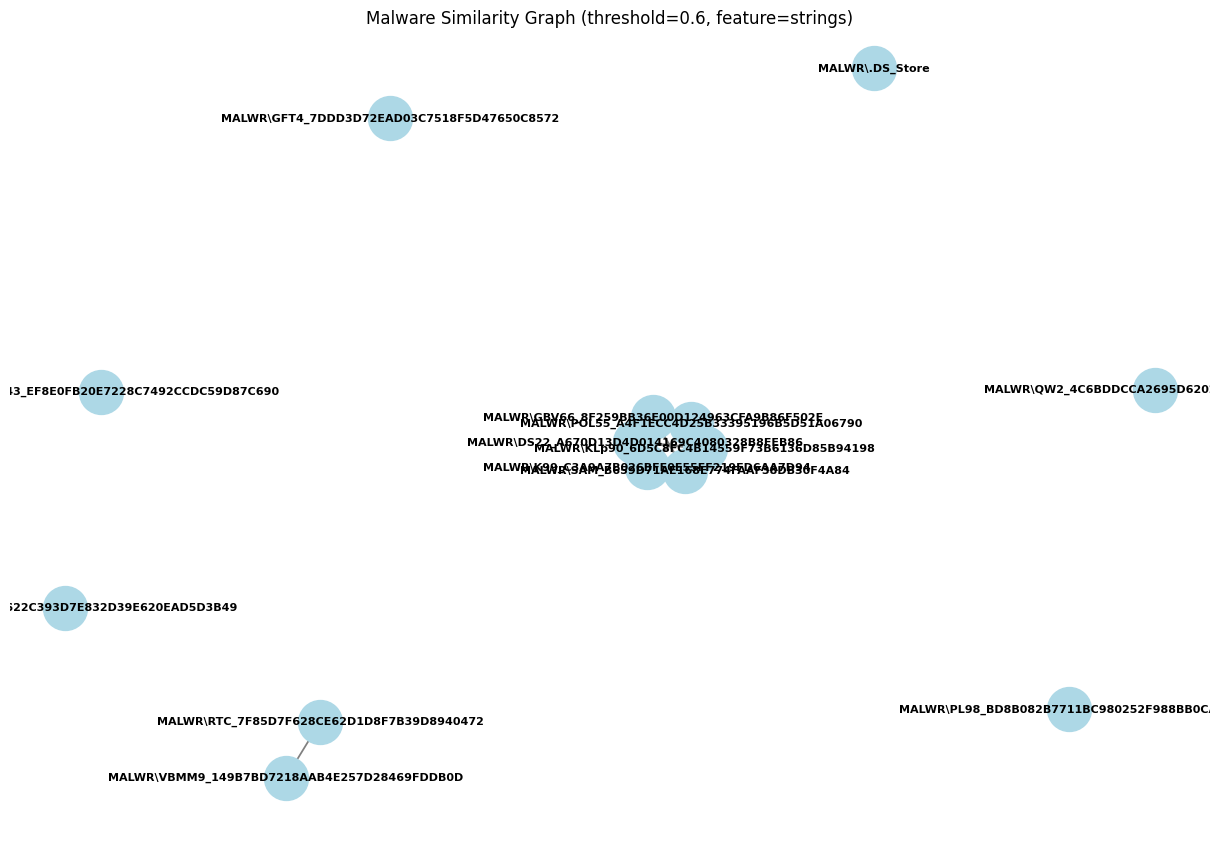


Threshold: 0.6
Number of nodes: 14
Number of edges: 16
Connected components: [{'MALWR\\.DS_Store'}, {'MALWR\\B98hX8E8622C393D7E832D39E620EAD5D3B49'}, {'MALWR\\SAM_B659D71AE168E774FAAF38DB30F4A84', 'MALWR\\KLp90_6D5C8FC4B14559F73B6136D85B94198', 'MALWR\\DS22_A670D13D4D014169C4080328B8FEB86', 'MALWR\\POL55_A4F1ECC4D25B33395196B5D51A06790', 'MALWR\\GBV66_8F259BB36E00D124963CFA9B86F502E', 'MALWR\\K99_C3A9A7B026BFE0E55FF219FD6AA7D94'}, {'MALWR\\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690'}, {'MALWR\\GFT4_7DDD3D72EAD03C7518F5D47650C8572'}, {'MALWR\\PL98_BD8B082B7711BC980252F988BB0CA936'}, {'MALWR\\QW2_4C6BDDCCA2695D6202DF38708E14FC7E'}, {'MALWR\\VBMM9_149B7BD7218AAB4E257D28469FDDB0D', 'MALWR\\RTC_7F85D7F628CE62D1D8F7B39D8940472'}]


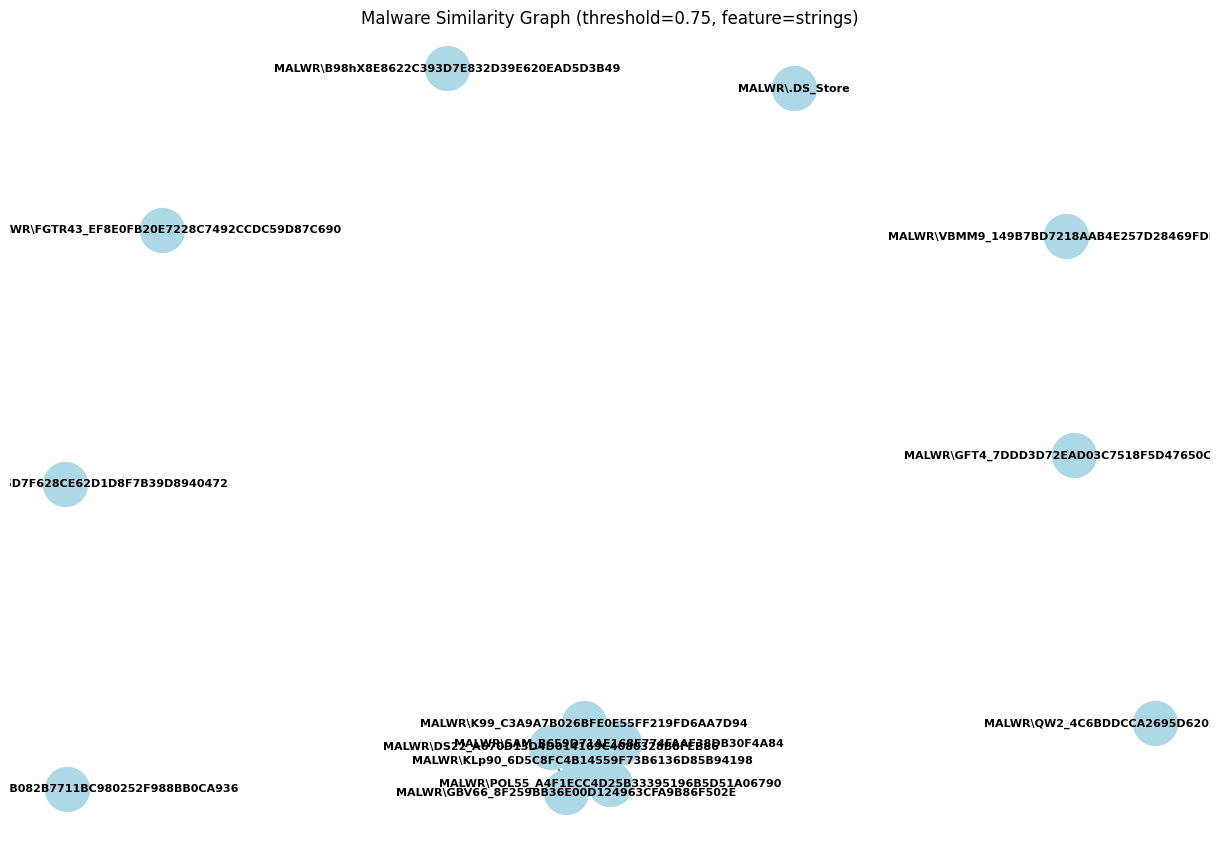


Threshold: 0.75
Number of nodes: 14
Number of edges: 15
Connected components: [{'MALWR\\.DS_Store'}, {'MALWR\\B98hX8E8622C393D7E832D39E620EAD5D3B49'}, {'MALWR\\SAM_B659D71AE168E774FAAF38DB30F4A84', 'MALWR\\KLp90_6D5C8FC4B14559F73B6136D85B94198', 'MALWR\\DS22_A670D13D4D014169C4080328B8FEB86', 'MALWR\\POL55_A4F1ECC4D25B33395196B5D51A06790', 'MALWR\\GBV66_8F259BB36E00D124963CFA9B86F502E', 'MALWR\\K99_C3A9A7B026BFE0E55FF219FD6AA7D94'}, {'MALWR\\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690'}, {'MALWR\\GFT4_7DDD3D72EAD03C7518F5D47650C8572'}, {'MALWR\\PL98_BD8B082B7711BC980252F988BB0CA936'}, {'MALWR\\QW2_4C6BDDCCA2695D6202DF38708E14FC7E'}, {'MALWR\\RTC_7F85D7F628CE62D1D8F7B39D8940472'}, {'MALWR\\VBMM9_149B7BD7218AAB4E257D28469FDDB0D'}]


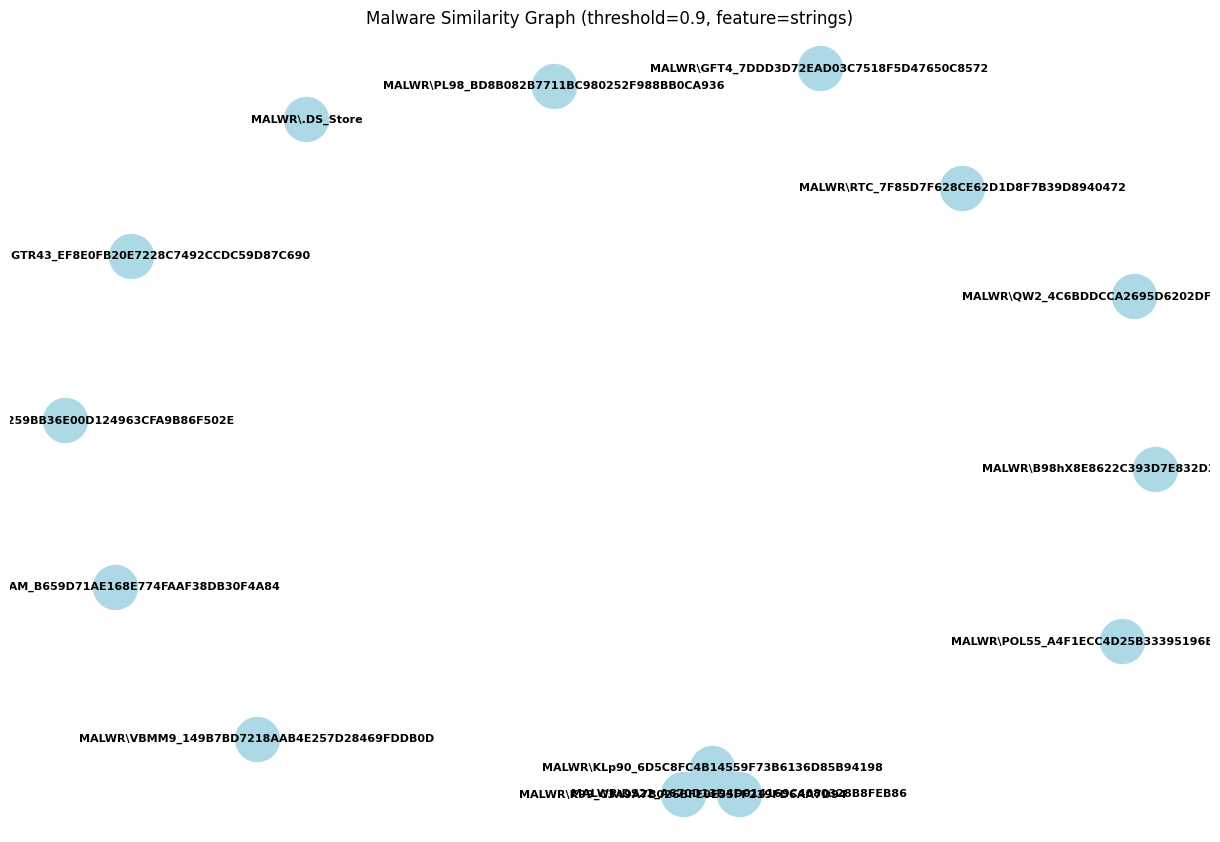


Threshold: 0.9
Number of nodes: 14
Number of edges: 3
Connected components: [{'MALWR\\.DS_Store'}, {'MALWR\\B98hX8E8622C393D7E832D39E620EAD5D3B49'}, {'MALWR\\K99_C3A9A7B026BFE0E55FF219FD6AA7D94', 'MALWR\\KLp90_6D5C8FC4B14559F73B6136D85B94198', 'MALWR\\DS22_A670D13D4D014169C4080328B8FEB86'}, {'MALWR\\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690'}, {'MALWR\\GBV66_8F259BB36E00D124963CFA9B86F502E'}, {'MALWR\\GFT4_7DDD3D72EAD03C7518F5D47650C8572'}, {'MALWR\\PL98_BD8B082B7711BC980252F988BB0CA936'}, {'MALWR\\POL55_A4F1ECC4D25B33395196B5D51A06790'}, {'MALWR\\QW2_4C6BDDCCA2695D6202DF38708E14FC7E'}, {'MALWR\\RTC_7F85D7F628CE62D1D8F7B39D8940472'}, {'MALWR\\SAM_B659D71AE168E774FAAF38DB30F4A84'}, {'MALWR\\VBMM9_149B7BD7218AAB4E257D28469FDDB0D'}]

Analyzing function calls...
Error extracting function calls from MALWR\.DS_Store: 'DOS Header magic not found.'
Extracted 0 function_calls from MALWR\.DS_Store
Extracted 11 function_calls from MALWR\B98hX8E8622C393D7E832D39E620EAD5D3B49
Extracted 85 function_c

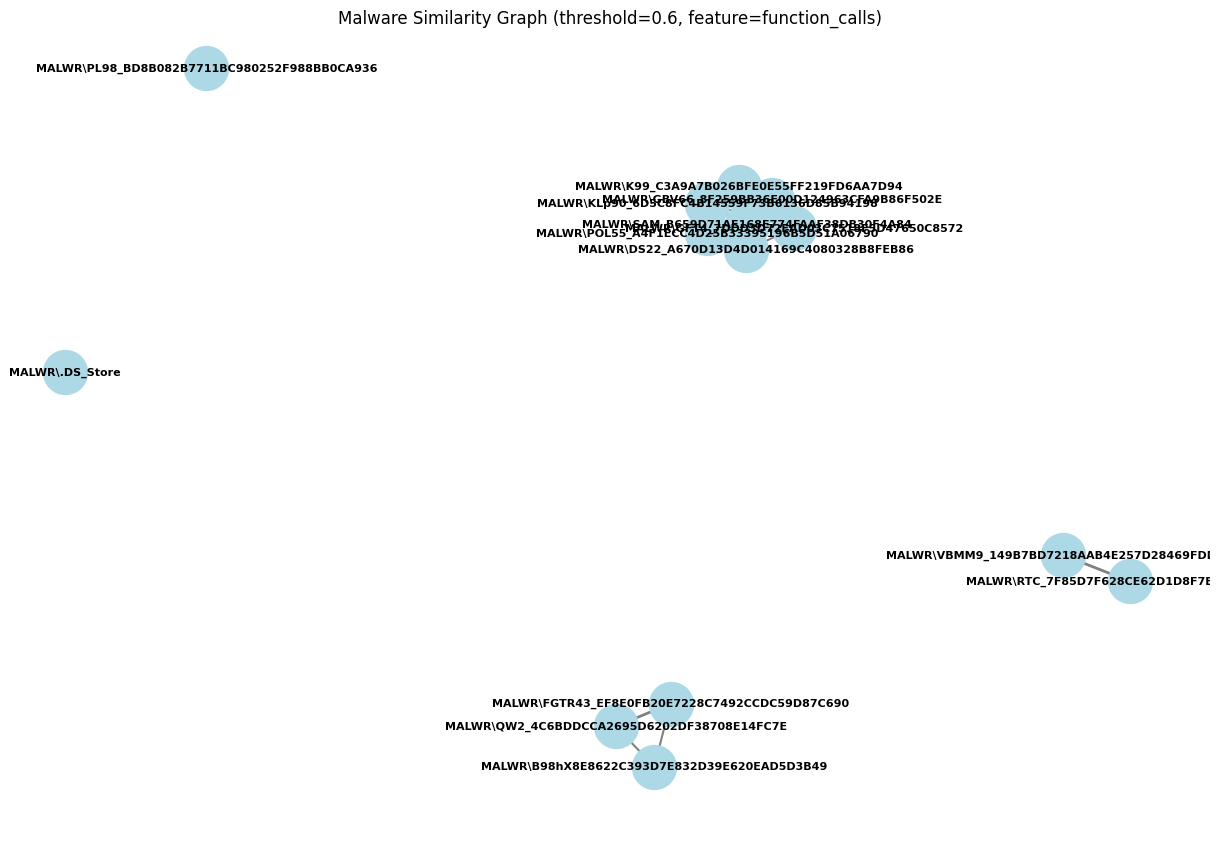


Threshold: 0.6
Number of nodes: 14
Number of edges: 25
Connected components: [{'MALWR\\.DS_Store'}, {'MALWR\\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690', 'MALWR\\QW2_4C6BDDCCA2695D6202DF38708E14FC7E', 'MALWR\\B98hX8E8622C393D7E832D39E620EAD5D3B49'}, {'MALWR\\SAM_B659D71AE168E774FAAF38DB30F4A84', 'MALWR\\KLp90_6D5C8FC4B14559F73B6136D85B94198', 'MALWR\\DS22_A670D13D4D014169C4080328B8FEB86', 'MALWR\\POL55_A4F1ECC4D25B33395196B5D51A06790', 'MALWR\\GFT4_7DDD3D72EAD03C7518F5D47650C8572', 'MALWR\\GBV66_8F259BB36E00D124963CFA9B86F502E', 'MALWR\\K99_C3A9A7B026BFE0E55FF219FD6AA7D94'}, {'MALWR\\PL98_BD8B082B7711BC980252F988BB0CA936'}, {'MALWR\\VBMM9_149B7BD7218AAB4E257D28469FDDB0D', 'MALWR\\RTC_7F85D7F628CE62D1D8F7B39D8940472'}]


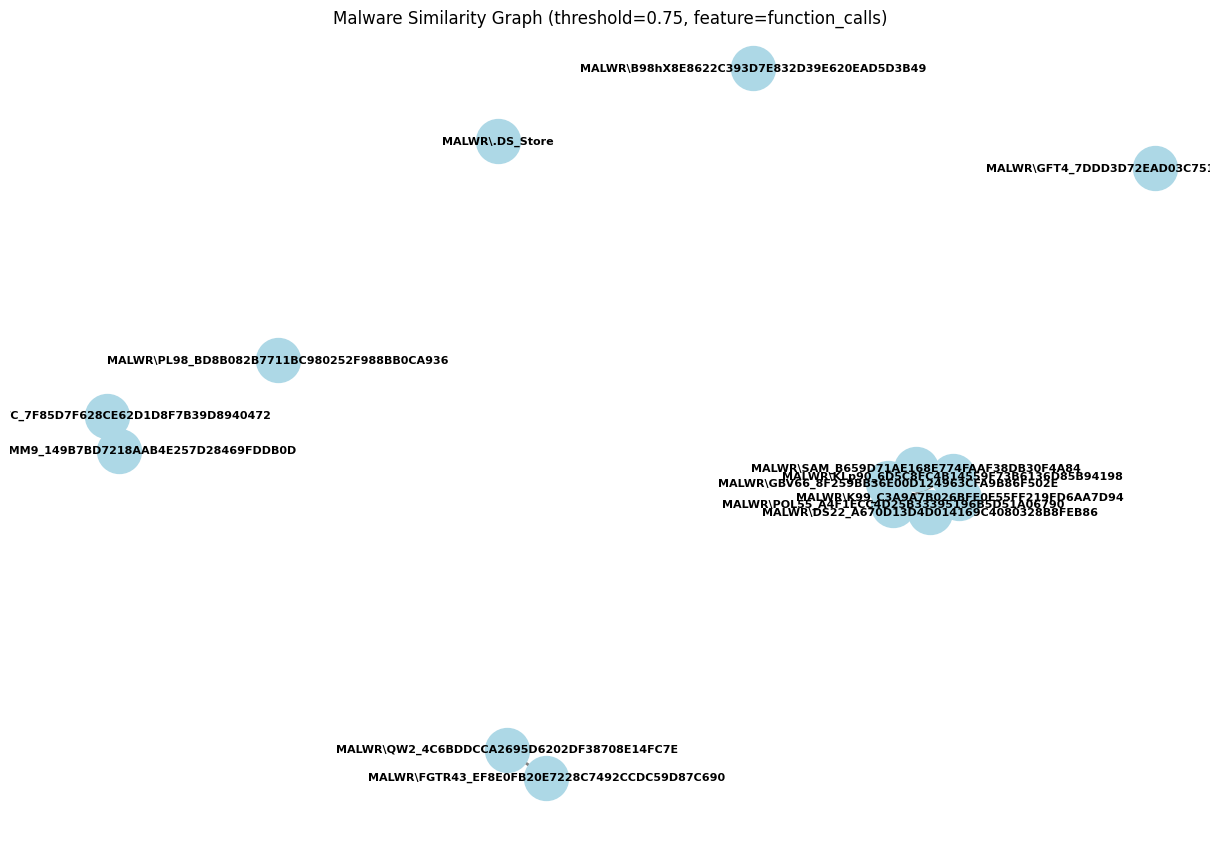


Threshold: 0.75
Number of nodes: 14
Number of edges: 17
Connected components: [{'MALWR\\.DS_Store'}, {'MALWR\\B98hX8E8622C393D7E832D39E620EAD5D3B49'}, {'MALWR\\SAM_B659D71AE168E774FAAF38DB30F4A84', 'MALWR\\KLp90_6D5C8FC4B14559F73B6136D85B94198', 'MALWR\\DS22_A670D13D4D014169C4080328B8FEB86', 'MALWR\\POL55_A4F1ECC4D25B33395196B5D51A06790', 'MALWR\\GBV66_8F259BB36E00D124963CFA9B86F502E', 'MALWR\\K99_C3A9A7B026BFE0E55FF219FD6AA7D94'}, {'MALWR\\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690', 'MALWR\\QW2_4C6BDDCCA2695D6202DF38708E14FC7E'}, {'MALWR\\GFT4_7DDD3D72EAD03C7518F5D47650C8572'}, {'MALWR\\PL98_BD8B082B7711BC980252F988BB0CA936'}, {'MALWR\\VBMM9_149B7BD7218AAB4E257D28469FDDB0D', 'MALWR\\RTC_7F85D7F628CE62D1D8F7B39D8940472'}]


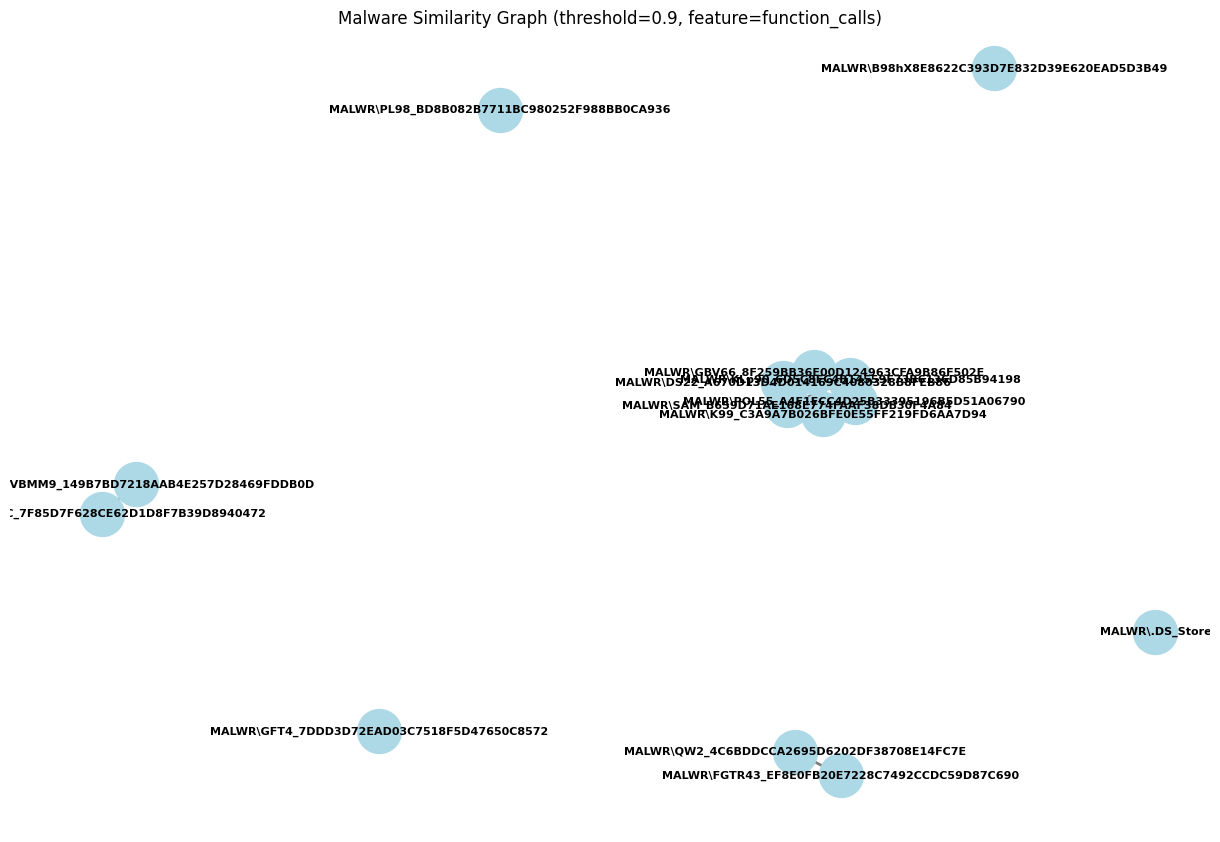


Threshold: 0.9
Number of nodes: 14
Number of edges: 17
Connected components: [{'MALWR\\.DS_Store'}, {'MALWR\\B98hX8E8622C393D7E832D39E620EAD5D3B49'}, {'MALWR\\SAM_B659D71AE168E774FAAF38DB30F4A84', 'MALWR\\KLp90_6D5C8FC4B14559F73B6136D85B94198', 'MALWR\\DS22_A670D13D4D014169C4080328B8FEB86', 'MALWR\\POL55_A4F1ECC4D25B33395196B5D51A06790', 'MALWR\\GBV66_8F259BB36E00D124963CFA9B86F502E', 'MALWR\\K99_C3A9A7B026BFE0E55FF219FD6AA7D94'}, {'MALWR\\FGTR43_EF8E0FB20E7228C7492CCDC59D87C690', 'MALWR\\QW2_4C6BDDCCA2695D6202DF38708E14FC7E'}, {'MALWR\\GFT4_7DDD3D72EAD03C7518F5D47650C8572'}, {'MALWR\\PL98_BD8B082B7711BC980252F988BB0CA936'}, {'MALWR\\VBMM9_149B7BD7218AAB4E257D28469FDDB0D', 'MALWR\\RTC_7F85D7F628CE62D1D8F7B39D8940472'}]


In [ ]:
# sacado del programa jac_analisis.py
import os
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
import itertools
import pefile
import matplotlib.pyplot as plt

def jaccard(set1, set2): # Función para calcular la similitud de Jaccard
    """Calculate Jaccard similarity between two sets"""
    intersection = set1.intersection(set2) # Calcular la intersección
    intersection_length = float(len(intersection)) # Longitud de la intersección 
    union = set1.union(set2) # Calcular la unión
    union_length = float(len(union)) # Longitud de la unión
    return intersection_length / union_length 

def getstrings(fullpath): # Función para extraer cadenas de un archivo
    """Extract strings from a file"""
    strings = os.popen(f'strings "{fullpath}"').read() # Ejecutar el comando strings
    strings = set(strings.split("\n")) # Convertir las cadenas en un conjunto
    return strings

def get_function_calls_from_pe(fullpath): # Función para extraer llamadas a funciones de un archivo PE
    """Extract function calls from PE file"""
    function_calls = set() # Conjunto que contendrá las llamadas a funciones
    try:
        pe = pefile.PE(fullpath) # Cargar el archivo PE
        for entry in pe.DIRECTORY_ENTRY_IMPORT: # Iterar sobre las entradas de la tabla de importación
            for function in entry.imports: # Iterar sobre las funciones importadas
                function_calls.add(function.name.decode('utf-8')) # Agregar la función al conjunto
    except Exception as e:
        print(f"Error extracting function calls from {fullpath}: {e}")
    return function_calls

def analyze_malware_similarity(malware_directory, output_directory, feature='strings'): # Función para analizar la similitud de malware
    """Analyze malware similarity using Jaccard index"""
    os.makedirs(output_directory, exist_ok=True) # Crear el directorio de salida si no existe
    
    # indices de umbral para la similitud de Jaccard
    thresholds = [0.6, 0.75, 0.9]
    
    
    malware_paths = [] # Lista que contendrá las rutas de los archivos de malware
    for root, dirs, paths in os.walk(malware_directory): # Iterar sobre los archivos de malware
        for path in paths: # Iterar sobre las rutas
            full_path = os.path.join(root, path) # Obtener la ruta completa
            malware_paths.append(full_path) # Agregar la ruta a la lista
    
    
    malware_attributes = {} # Diccionario que contendrá los atributos de malware
    for path in malware_paths: # Iterar sobre las rutas de malware
        if feature == 'strings': # Si el atributo es cadenas
            attributes = getstrings(path) # Extraer cadenas
        elif feature == 'function_calls': # Si el atributo es llamadas a funciones
            attributes = get_function_calls_from_pe(path) # Extraer llamadas a funciones
        print(f"Extracted {len(attributes)} {feature} from {path}") # Mostrar el número de atributos extraídos
        malware_attributes[path] = attributes
    
    # Crear grafos de similitud de malware
    graphs = []
    for threshold in thresholds: # Iterar sobre los umbrales
        output_dot_file = os.path.join(output_directory, f"umbral_{threshold}_{feature}.dot") # Archivo de salida
        graph = nx.Graph() # Crear un grafo
        
        # Agregar nodos
        for path in malware_paths:
            graph.add_node(path, label=os.path.split(path)[-1][:10]) # Agregar nodo con la etiqueta del archivo
        
        # Agregar bordes basados en la similitud de Jaccard
        for malware1, malware2 in itertools.combinations(malware_paths, 2): # Iterar sobre las combinaciones de malware
            jaccard_index = jaccard(malware_attributes[malware1], malware_attributes[malware2]) # Calcular la similitud de Jaccard
            if jaccard_index > threshold: # Si la similitud es mayor que el umbral
                graph.add_edge(malware1, malware2, weight=jaccard_index) # Agregar el borde con el peso
        
        graphs.append((threshold, graph)) # Agregar el grafo a la lista de grafos
        write_dot(graph, output_dot_file) # Escribir el grafo en un archivo DOT
        
        # Visualizar el grafo
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, 
                node_color='lightblue',
                with_labels=True,
                node_size=1000,
                font_size=8,
                font_weight='bold',
                edge_color='gray',
                width=[graph[u][v]['weight']*2 for u,v in graph.edges()])
        plt.title(f'Malware Similarity Graph (threshold={threshold}, feature={feature})')
        plt.show()
        
        # Mostrar información del grafo
        print(f"\nThreshold: {threshold}")
        print(f"Number of nodes: {graph.number_of_nodes()}")
        print(f"Number of edges: {graph.number_of_edges()}")
        print("Connected components:", list(nx.connected_components(graph)))
    
    return graphs


malware_dir = "MALWR"  # Directorio de malware
output_dir_strings = "Results/Strings" # Directorio de salida para cadenas 
output_dir_functions = "Results/FunctionCalls" # Directorio de salida para llamadas a funciones

# Analizar cadenas
print("Analyzing strings...")
graphs_strings = analyze_malware_similarity(malware_dir, output_dir_strings, 'strings')

# Analizar llamadas a funciones
print("\nAnalyzing function calls...")
graphs_functions = analyze_malware_similarity(malware_dir, output_dir_functions, 'function_calls')

# Conclusiones
1. Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette
más alto?

R//

2. Para ambos algoritmos, ¿En que medida coincide el coeficiente de Silhouette con el método
del codo?

R//

3. Según los resultados obtenidos de ambos algoritmos ¿Cuántas familias cree que existen entre
los ejemplares de malware proporcionados?

R//

4. ¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los
algoritmos de partición, para ambas características (strings, llamadas a las funciones)?

R//